In [1]:
from influxdb import InfluxDBClient # install via "pip install influxdb"
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
#this is a comment

client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df



In [2]:
# Get the last 90 days of power generation data
generation = client.query(
    "SELECT * FROM Generation where time > now()-90d Order by time desc"
    ) # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind  = client.query(
    "SELECT * FROM MetForecasts where time > now()-90d and time <= now() and Lead_hours = '1' Order by time desc"
    ) # Query written in InfluxQL

gen_df = get_df(generation)
wind_df = get_df(wind)
wind_df.replace({
    "N":math.radians(0), 
    "NNE":math.radians(22.5), 
    "NE":math.radians(45),
    "ENE":math.radians(67.5),
    "E":math.radians(90), 
    "ESE":math.radians(111.5), 
    "SE":math.radians(135), 
    "SSE":math.radians(157.5),
    "S":math.radians(180), 
    "SSW":math.radians(202.5), 
    "SW":math.radians(225), 
    "WSW":math.radians(247.5), 
    "W":math.radians(270), 
    "WNW":math.radians(292.5), 
    "NW":math.radians(315), 
    "NNW":math.radians(337.5)}, 
    inplace=True)

#df_aligned = pd.concat([wind_df, gen_df], axis=1, join='outer').fillna(method='ffill').fillna(method='bfill')
df_aligned = pd.concat([wind_df, gen_df], axis=1, join = "inner")
df_aligned = df_aligned.dropna()

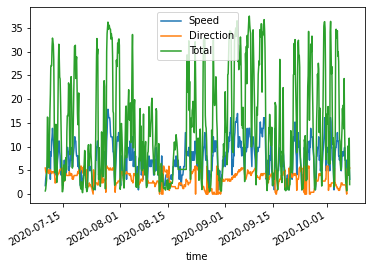

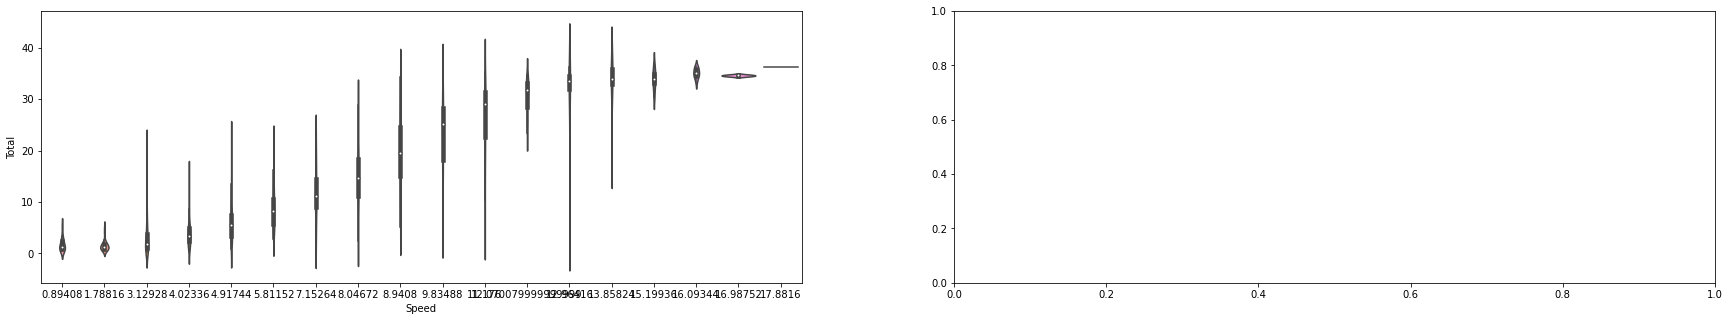

In [3]:
Data =df_aligned[["Speed","Direction","Total"]]
Data.plot()
plt.show()

fig, axs = plt.subplots(ncols=2, figsize=(30,5))
sns.violinplot(x="Speed", y="Total", data=df_aligned, ax=axs[0])

In [4]:
Data["Time"] = Data.index.values #adding "Time" as column instead of index
#define x and y 
X = Data[["Time", "Speed", "Direction"]]
Y = Data[["Total"]]
#print(X)
#print(Y)

MAE: 4.011409262496362


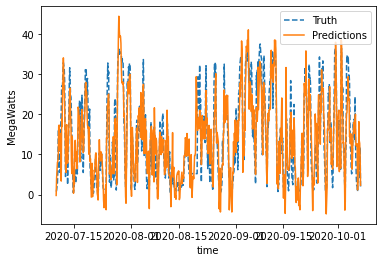

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

class Debug(BaseEstimator, TransformerMixin):
    def fit(self, X, Y): return self
    def transform(self, X):
       # print(X)
        return X

class DateToTimeStamp(BaseEstimator, TransformerMixin):
    def fit(self, X, Y):
        return self

    def transform(self,X):
        X["timestamp"] = [pd.to_datetime(d).timestamp() for d in 
        X["Time"].values]
        return X

class HourAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, Y):
        return self

    def transform(self, X):
        X["hour"] = [pd.to_datetime(d).hour for d in 
        X["Time"].values]
        return X

class SpeedAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, Y):
        return self

    def transform(self, X):
        X["Speed"] = [pd.to_datetime(d).hour for d in 
        X["Speed"].values]
        return X

# Align the data frames

pipeline = Pipeline([
    ("DateToTimeStamp", DateToTimeStamp()),
    ("HourAdder", HourAdder()),
    ("Drop time", ColumnTransformer([
        ("Drop time", "drop", ["Time"]),
        ("Hour to Onehot", OneHotEncoder(), ["hour"])
        ], remainder="passthrough")),
    ("Debug", Debug()),
    ("LinRegModel", LinearRegression())
    #("Knn", KNeighborsRegressor(5))
])

# Fit the pipeline
pipeline.fit(X,Y)

Y_hat = pipeline.predict(X)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(Y, Y_hat)

print ("MAE:", mae)

'''from sklearn.model_selection import KFold

split = KFold(5)

for train, test in split.split(X,Y):
    X_train, X_test = X.iloc[train].copy(), X.iloc[test].copy()
    Y_train, Y_test = Y.iloc[train].copy(), Y.iloc[test].copy()

    pipeline.fit(X_train, Y_train)
    Y_train_hat = pipeline.predict(X_test)
    mea = mean_absolute_error(Y_test, Y_train_hat)
    print("Fold MEA:", mea)'''

plt.plot(df_aligned.index, Y, "--", label = "Truth")
plt.plot(df_aligned.index, Y_hat, label = "Predictions")
plt.xlabel("time")
plt.ylabel("MegaWatts")
plt.legend()
plt.show()